In [1]:
import copy
import pickle
import sys
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.framework.errors_impl import NotFoundError

from src.cfd import CFD
from src.dataset import X_TIME, load_expanded_dataset_train_val, TIME_STEP, load_expanded_dataset_train_test, \
    ExpandedDataset
from src.gauss_hist import get_gauss_stats, plot_gauss_hist
from src.models import optimal_model_builder_all_ch
from src.network_utils import train_model as _base_train_model, gaussian_kernel, plot_difference_hist
from src.utils import print_pairwise_precisions

PWD = '../../..'
sys.path.append(PWD)

OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

In [2]:
BASE_CFD_THRESHOLD = 0.2
CFD_N_BASELINE = 6

base_cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=BASE_CFD_THRESHOLD)

In [3]:
N_BASELINE = 6

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 1000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

LR_PATIENCE = 5
ES_PATIENCE = 50

OVERWRITE = False

In [4]:
base_dataset, _ = load_expanded_dataset_train_test(PWD)
train_dataset, val_dataset = load_expanded_dataset_train_val(PWD)
train_dataset.t_avg.shape, val_dataset.t_avg.shape

((26719,), (6680,))

In [5]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

cfd_by_channel = {(p, ch): CFD(n_baseline=N_BASELINE, threshold=thresh) for (p, ch), thresh in
                  optimal_cfd_thresholds.items()}

Optimal thresholds:
(1,  2): 0.180
(1, 11): 0.185
(2,  2): 0.220
(2, 11): 0.145
(3,  2): 0.130
(3, 11): 0.175


# Utils

In [6]:
def build_nn_dataset(dataset: ExpandedDataset) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    x, y = [], []
    for key, data in dataset.wav.items():
        t_data = dataset.t_ref[key]
        for i in range(len(t_data)):
            if np.isnan(t_data[i]):
                continue
            wav = data[i]
            true_t = t_data[i]

            x.append(wav)
            y.append(true_t)

    x, y = np.array(x), np.array(y)

    # UNet
    y_network = np.array([gaussian_kernel(t) for t in y])

    return x, y, y_network


def build_and_train_network(iteration: int, x_train: np.ndarray, x_val: np.ndarray, y_train: np.ndarray,
                            y_val: np.ndarray, overwrite: bool = OVERWRITE,
                            verbose: int = 2) -> tuple[keras.Model, pd.DataFrame]:
    model = optimal_model_builder_all_ch()
    name = f"optimal_it_{iteration}"
    if overwrite:
        history = _base_train_model(model, name, "iti_experiments", x_train, y_train, x_val, y_val, LR, True, N_EPOCHS,
                                    verbose, BATCH_SIZE, LR_PATIENCE, ES_PATIENCE, ES_MIN_DELTA, LOSS_WEIGHT,
                                    root=PWD + '/data')
    else:
        try:
            history = _base_train_model(model, name, "iti_experiments", x_train, y_train, x_val, y_val, LR, False,
                                        N_EPOCHS,
                                        verbose, BATCH_SIZE, LR_PATIENCE, ES_PATIENCE, ES_MIN_DELTA, LOSS_WEIGHT,
                                        root=PWD + '/data')
        except NotFoundError:
            history = _base_train_model(model, name, "iti_experiments", x_train, y_train, x_val, y_val, LR, True,
                                        N_EPOCHS,
                                        verbose, BATCH_SIZE, LR_PATIENCE, ES_PATIENCE, ES_MIN_DELTA, LOSS_WEIGHT,
                                        root=PWD + '/data')

    return model, history


def pred_model(model: keras.Model, x: np.ndarray) -> np.ndarray:
    y_pred = model.predict(x, batch_size=BATCH_SIZE)

    # UNet
    y_pred_t = np.empty(y_pred.shape[0])
    for i, y in enumerate(y_pred):
        _, y_pred_t[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred_t


def evaluate_model_wrt_cfd_average(model: keras.Model, x: np.ndarray, y_true_t: np.ndarray, show: bool = True) -> float:
    y_pred = pred_model(model, x)
    std, _, _ = plot_difference_hist(y_true_t, y_pred, show=show)
    return std


def build_updated_dataset(model: keras.Model, dataset: ExpandedDataset) -> ExpandedDataset:
    dataset_t0_updated = {}
    dataset_t_pred_updated = {}
    dataset_len = len(dataset)
    dataset_avg = np.zeros(dataset_len)
    dataset_avg_count = np.zeros(dataset_len)

    for key in dataset.keys():
        print(f'Processing channel {key}...')
        # compute updated t0
        wav_array = dataset.wav[key]
        t0_array = dataset.t0[key].copy()

        mask = dataset.notnan_mask[key]
        t0_temp = t0_array[mask]
        t_pred_array_temp = pred_model(model, wav_array[mask])
        t_pred_array = np.full(dataset_len, np.nan)
        t_pred_array[mask] = t_pred_array_temp

        t_fixed = t0_temp + t_pred_array_temp
        t_mean = np.mean(t_fixed)

        t0_array[mask] -= t_mean
        dataset_t0_updated[key] = t0_array
        dataset_t_pred_updated[key] = t_pred_array

        # add to avg
        dataset_avg[mask] += t0_array[mask] + t_pred_array_temp
        dataset_avg_count[mask] += 1

    dataset_avg /= dataset_avg_count

    return ExpandedDataset(t_avg=dataset_avg, wav=dataset.wav, t0=dataset_t0_updated, t_pred=dataset_t_pred_updated)


def compute_pairwise_precisions(dataset: ExpandedDataset, show_hists: bool = True) -> dict[tuple[int, int], float]:
    dataset_t = copy.deepcopy(dataset.t0)
    for key in dataset.t_pred.keys():
        mask = dataset.notnan_mask[key]
        dataset_t[key][mask] += dataset.t_pred[key][mask]

    pairwise_precisions = {}
    for p_ch1, p_ch2 in combinations(dataset_t.keys(), 2):
        if p_ch1[1] == p_ch2[1]:  # Only for corresponding channels
            ch1_timestamps, ch2_timestamps = dataset_t[p_ch1], dataset_t[p_ch2]
            differences = [ch2_t - ch1_t for ch1_t, ch2_t in zip(ch1_timestamps, ch2_timestamps) if
                           not np.isnan(ch1_t) and not np.isnan(ch2_t)]

            # _, std, _, _ = plot_gauss_hist(differences, show=False)
            std = np.std(differences)
            pairwise_precisions[(p_ch1, p_ch2)] = std * 1000  # ns -> ps

    # plt.title("Difference histograms for validation purposes")
    # if show_hists:
    #     plt.show()
    # else:
    #     plt.close()

    return pairwise_precisions


def get_avg_pairwise_prec_and_log_pairwise(dataset: ExpandedDataset) -> tuple[float, dict]:
    pairwise_precisions = compute_pairwise_precisions(dataset)
    print_pairwise_precisions(pairwise_precisions)

    avg_prec = np.average(list(pairwise_precisions.values()))
    print(f"Average: {avg_prec:0.2f} ps")
    return avg_prec, pairwise_precisions

In [7]:
x_train, y_train_t, y_train = build_nn_dataset(train_dataset)
x_val, y_val_t, y_val = build_nn_dataset(val_dataset)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((80157, 24), (20040, 24), (80157, 24), (20040, 24))

In [8]:
avg_pairwise_prec_by_it: dict[int, float] = {}
pairwise_prec_by_it: dict[int, dict] = {}
loss_by_it: dict[int, float] = {}

In [9]:
avg_pairwise_prec_by_it[0], pairwise_prec_by_it[0] = get_avg_pairwise_prec_and_log_pairwise(val_dataset)

ch  2: (p1 vs p2): 87.19 ps
ch  2: (p1 vs p3): 105.31 ps
ch  2: (p2 vs p3): 109.58 ps
ch 11: (p1 vs p2): 99.96 ps
ch 11: (p1 vs p3): 122.54 ps
ch 11: (p2 vs p3): 128.26 ps
Average: 108.81 ps


# Test

## Iteration 1

### 1.1. Train Model

In [10]:
model_it1, history = build_and_train_network(iteration=1, x_train=x_train, x_val=x_val, y_train=y_train, y_val=y_val)
loss_by_it[1] = min(history['val_loss'])

### 1.2. Evaluate wrt CFD averages

3/3 [==============================] - 2s 88ms/step


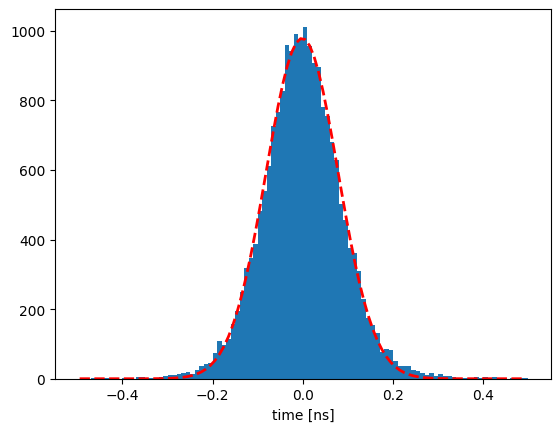

Iteration 1. std wrt. CFD average: 79.88 ps


In [11]:
std = evaluate_model_wrt_cfd_average(model_it1, x_val, y_val_t)
print(f"Iteration 1. std wrt. CFD average: {std * 1000:0.2f} ps")

### 1.3. Update dataset

In [12]:
base_dataset_it1 = build_updated_dataset(model_it1, base_dataset)

Processing channel (1, 2)...
2/2 [==============================] - 0s 246ms/step
Processing channel (1, 11)...
3/3 [==============================] - 0s 170ms/step
Processing channel (2, 2)...
2/2 [==============================] - 0s 355ms/step
Processing channel (2, 11)...
3/3 [==============================] - 0s 196ms/step
Processing channel (3, 2)...
2/2 [==============================] - 0s 416ms/step
Processing channel (3, 11)...
3/3 [==============================] - 0s 200ms/step


In [13]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset_it1)), test_size=0.2, random_state=42)
train_dataset_it1 = base_dataset_it1.extract_by_idx(train_idx)
val_dataset_it1 = base_dataset_it1.extract_by_idx(val_idx)

x_train_it1, y_train_t_it1, y_train_it1 = build_nn_dataset(train_dataset_it1)
x_val_it1, y_val_t_it1, y_val_it1 = build_nn_dataset(val_dataset_it1)

x_train_it1.shape, y_train_it1.shape, x_val_it1.shape, y_val_it1.shape

((80157, 24), (80157, 24), (20040, 24), (20040, 24))

### 1.4 Evaluate pairwise precision

In [14]:
avg_pairwise_prec_by_it[1], pairwise_prec_by_it[1] = get_avg_pairwise_prec_and_log_pairwise(val_dataset_it1)

ch  2: (p1 vs p2): 76.16 ps
ch  2: (p1 vs p3): 96.66 ps
ch  2: (p2 vs p3): 97.03 ps
ch 11: (p1 vs p2): 83.95 ps
ch 11: (p1 vs p3): 103.33 ps
ch 11: (p2 vs p3): 108.77 ps
Average: 94.32 ps


## Iteration 2

### 2.1. Train model

In [15]:
model_it2, history = build_and_train_network(iteration=2, x_train=x_train_it1, x_val=x_val_it1, y_train=y_train_it1,
                                             y_val=y_val_it1)
loss_by_it[2] = min(history['val_loss'])

### 2.2. Evaluate wrt CFD averages

3/3 [==============================] - 1s 150ms/step


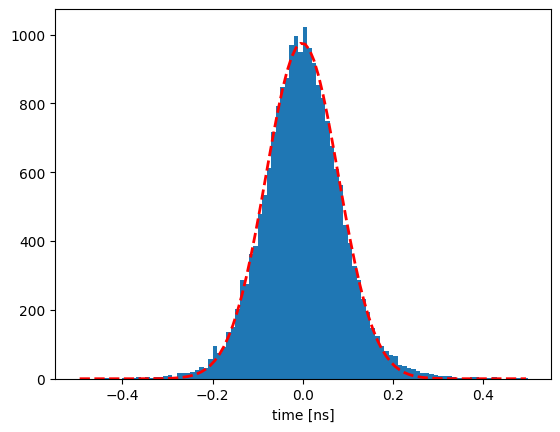

Iteration 2. std wrt. CFD average: 80.17 ps


In [16]:
std = evaluate_model_wrt_cfd_average(model_it2, x_val, y_val_t)
print(f"Iteration 2. std wrt. CFD average: {std * 1000:0.2f} ps")

### 2.3. Update dataset

In [17]:
base_dataset_it2 = build_updated_dataset(model_it2, base_dataset_it1)

Processing channel (1, 2)...
2/2 [==============================] - 0s 324ms/step
Processing channel (1, 11)...
3/3 [==============================] - 0s 73ms/step
Processing channel (2, 2)...
2/2 [==============================] - 0s 241ms/step
Processing channel (2, 11)...
3/3 [==============================] - 0s 73ms/step
Processing channel (3, 2)...
2/2 [==============================] - 0s 230ms/step
Processing channel (3, 11)...
3/3 [==============================] - 0s 146ms/step


In [18]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset_it2)), test_size=0.2, random_state=42)
train_dataset_it2 = base_dataset_it2.extract_by_idx(train_idx)
val_dataset_it2 = base_dataset_it2.extract_by_idx(val_idx)

x_train_it2, y_train_t_it2, y_train_it2 = build_nn_dataset(train_dataset_it2)
x_val_it2, y_val_t_it2, y_val_it2 = build_nn_dataset(val_dataset_it2)

x_train_it2.shape, y_train_it2.shape, x_val_it2.shape, y_val_it2.shape

((80157, 24), (80157, 24), (20040, 24), (20040, 24))

### 2.4. Evaluate pairwise precision

In [19]:
avg_pairwise_prec_by_it[2], pairwise_prec_by_it[2] = get_avg_pairwise_prec_and_log_pairwise(val_dataset_it2)

ch  2: (p1 vs p2): 74.48 ps
ch  2: (p1 vs p3): 94.79 ps
ch  2: (p2 vs p3): 95.30 ps
ch 11: (p1 vs p2): 81.26 ps
ch 11: (p1 vs p3): 100.77 ps
ch 11: (p2 vs p3): 106.55 ps
Average: 92.19 ps


## Iteration 3

### 3.1 Train model

In [20]:
model_it3, history = build_and_train_network(iteration=3, x_train=x_train_it2, x_val=x_val_it2, y_train=y_train_it2,
                                             y_val=y_val_it2)
loss_by_it[3] = min(history['val_loss'])

### 3.2. Evaluate wrt CFD averages

3/3 [==============================] - 1s 217ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


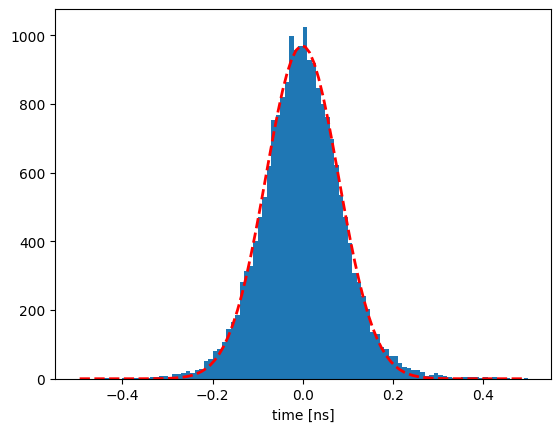

Iteration 3. std wrt. CFD average: 80.66 ps


In [21]:
std = evaluate_model_wrt_cfd_average(model_it3, x_val, y_val_t)
print(f"Iteration 3. std wrt. CFD average: {std * 1000:0.2f} ps")

### 3.3. Update dataset

In [22]:
base_dataset_it3 = build_updated_dataset(model_it3, base_dataset_it2)

Processing channel (1, 2)...
2/2 [==============================] - 0s 278ms/step
Processing channel (1, 11)...
3/3 [==============================] - 0s 135ms/step
Processing channel (2, 2)...
2/2 [==============================] - 0s 281ms/step
Processing channel (2, 11)...
3/3 [==============================] - 0s 138ms/step
Processing channel (3, 2)...
2/2 [==============================] - 0s 287ms/step
Processing channel (3, 11)...
3/3 [==============================] - 0s 157ms/step


In [23]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset_it3)), test_size=0.2, random_state=42)
train_dataset_it3 = base_dataset_it3.extract_by_idx(train_idx)
val_dataset_it3 = base_dataset_it3.extract_by_idx(val_idx)

x_train_it3, y_train_t_it3, y_train_it3 = build_nn_dataset(train_dataset_it3)
x_val_it3, y_val_t_it3, y_val_it3 = build_nn_dataset(val_dataset_it3)

x_train_it3.shape, y_train_it3.shape, x_val_it3.shape, y_val_it3.shape

((80157, 24), (80157, 24), (20040, 24), (20040, 24))

### 3.4. Evaluate pairwise precision

In [24]:
avg_pairwise_prec_by_it[3], pairwise_prec_by_it[3] = get_avg_pairwise_prec_and_log_pairwise(val_dataset_it3)

ch  2: (p1 vs p2): 73.99 ps
ch  2: (p1 vs p3): 93.51 ps
ch  2: (p2 vs p3): 94.00 ps
ch 11: (p1 vs p2): 79.86 ps
ch 11: (p1 vs p3): 99.46 ps
ch 11: (p2 vs p3): 105.06 ps
Average: 90.98 ps


## Iteration 4

### 4.1. Train Model

In [25]:
model_it4, history = build_and_train_network(iteration=4, x_train=x_train_it3, x_val=x_val_it3, y_train=y_train_it3,
                                             y_val=y_val_it3)
loss_by_it[4] = min(history['val_loss'])

### 4.2. Evaluate wrt CFD averages

3/3 [==============================] - 1s 220ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


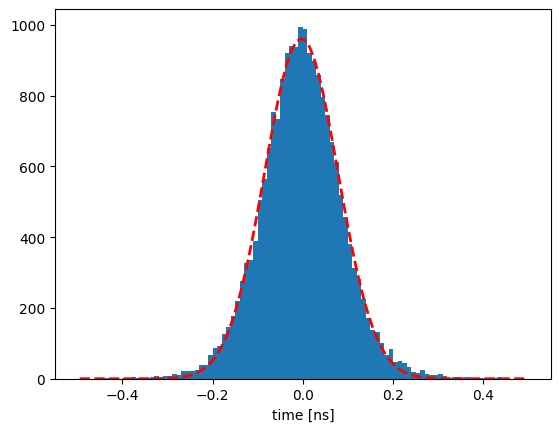

Iteration 4. std wrt. CFD average: 81.33 ps


In [26]:
std = evaluate_model_wrt_cfd_average(model_it4, x_val, y_val_t)
print(f"Iteration 4. std wrt. CFD average: {std * 1000:0.2f} ps")

### 4.3. Update dataset

In [27]:
base_dataset_it4 = build_updated_dataset(model_it4, base_dataset_it3)

Processing channel (1, 2)...
2/2 [==============================] - 0s 221ms/step
Processing channel (1, 11)...
3/3 [==============================] - 0s 69ms/step
Processing channel (2, 2)...
2/2 [==============================] - 0s 261ms/step
Processing channel (2, 11)...
3/3 [==============================] - 0s 126ms/step
Processing channel (3, 2)...
2/2 [==============================] - 0s 208ms/step
Processing channel (3, 11)...
3/3 [==============================] - 0s 69ms/step


In [28]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset_it4)), test_size=0.2, random_state=42)
train_dataset_it4 = base_dataset_it4.extract_by_idx(train_idx)
val_dataset_it4 = base_dataset_it4.extract_by_idx(val_idx)

x_train_it4, y_train_t_it4, y_train_it4 = build_nn_dataset(train_dataset_it4)
x_val_it4, y_val_t_it4, y_val_it4 = build_nn_dataset(val_dataset_it4)

x_train_it4.shape, y_train_it4.shape, x_val_it4.shape, y_val_it4.shape

((80157, 24), (80157, 24), (20040, 24), (20040, 24))

### 4.4 Evaluate pairwise precision

In [29]:
avg_pairwise_prec_by_it[4], pairwise_prec_by_it[4] = get_avg_pairwise_prec_and_log_pairwise(val_dataset_it4)

ch  2: (p1 vs p2): 73.73 ps
ch  2: (p1 vs p3): 93.18 ps
ch  2: (p2 vs p3): 93.57 ps
ch 11: (p1 vs p2): 79.17 ps
ch 11: (p1 vs p3): 99.19 ps
ch 11: (p2 vs p3): 104.36 ps
Average: 90.53 ps


# Experiment Conclusion

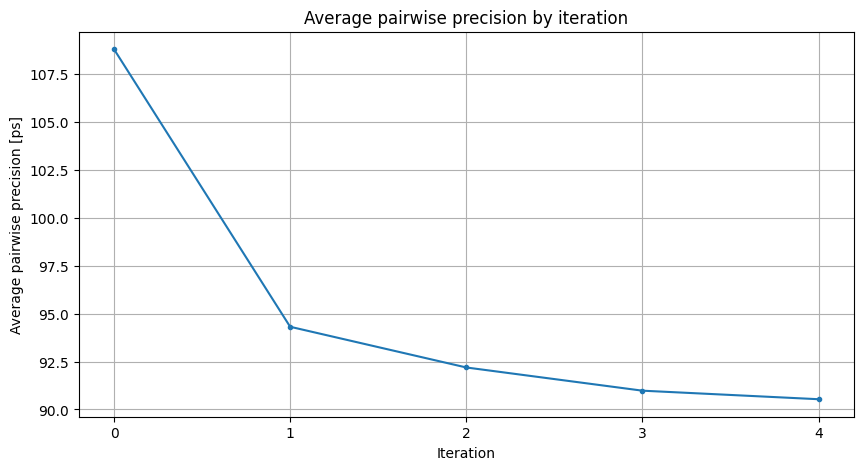

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(avg_pairwise_prec_by_it.keys(), avg_pairwise_prec_by_it.values(), marker='.')
plt.xticks(list(avg_pairwise_prec_by_it.keys()))
plt.title('Average pairwise precision by iteration')
plt.xlabel('Iteration')
plt.ylabel('Average pairwise precision [ps]')
plt.grid()
plt.show()

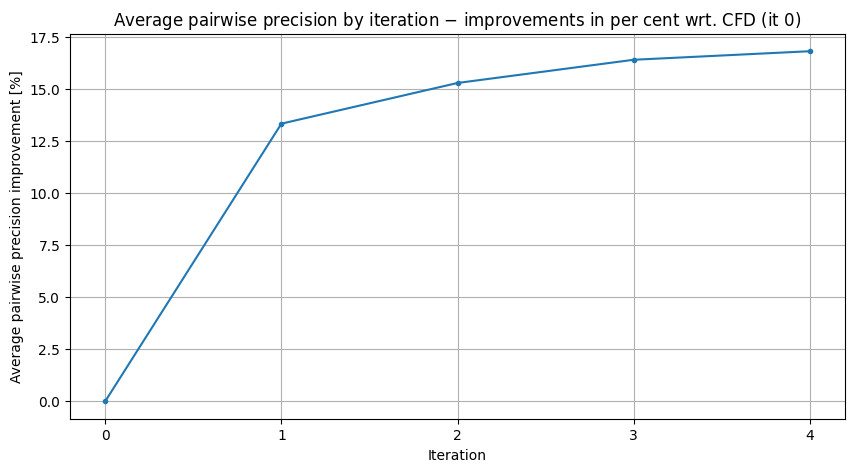

In [31]:
plt.figure(figsize=(10, 5))
percent_improvements = np.array(list(avg_pairwise_prec_by_it.values()))
percent_improvements = (1 - (percent_improvements / percent_improvements[0])) * 100
plt.plot(avg_pairwise_prec_by_it.keys(), percent_improvements, marker='.')
plt.xticks(list(avg_pairwise_prec_by_it.keys()))
plt.title('Average pairwise precision by iteration $-$ improvements in per cent wrt. CFD (it 0)')
plt.xlabel('Iteration')
plt.ylabel('Average pairwise precision improvement [%]')
plt.grid()
plt.show()

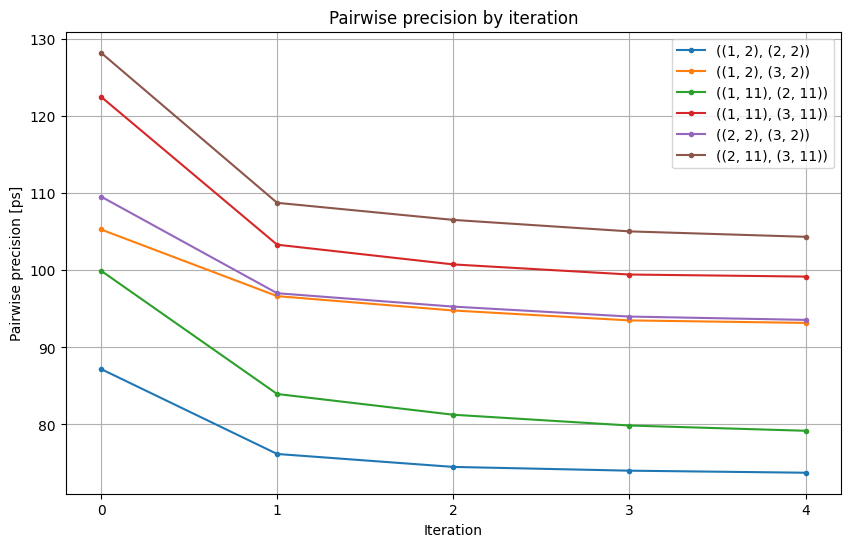

In [32]:
plt.figure(figsize=(10, 6))

it_pairwise_prec_by_channel = defaultdict(list)
for it, pairwise_prec in pairwise_prec_by_it.items():
    for p_ch_pair, prec in pairwise_prec.items():
        it_pairwise_prec_by_channel[p_ch_pair].append(prec)

for p_ch_pair, prec in it_pairwise_prec_by_channel.items():
    plt.plot(np.arange(len(prec)), prec, marker='.', label=str(p_ch_pair))

plt.xticks(list(avg_pairwise_prec_by_it.keys()))
plt.title('Pairwise precision by iteration')
plt.xlabel('Iteration')
plt.ylabel('Pairwise precision [ps]')
plt.legend()
plt.grid()
plt.show()

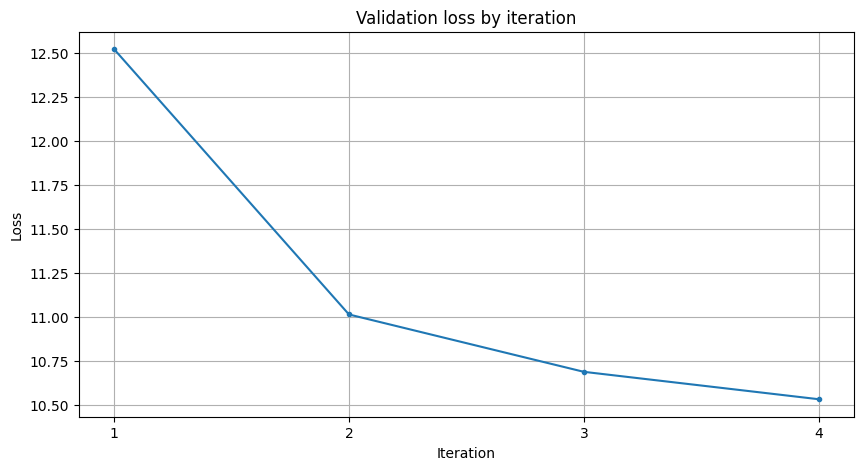

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(loss_by_it.keys(), loss_by_it.values(), marker='.')
plt.xticks(list(loss_by_it.keys()))
plt.title('Validation loss by iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

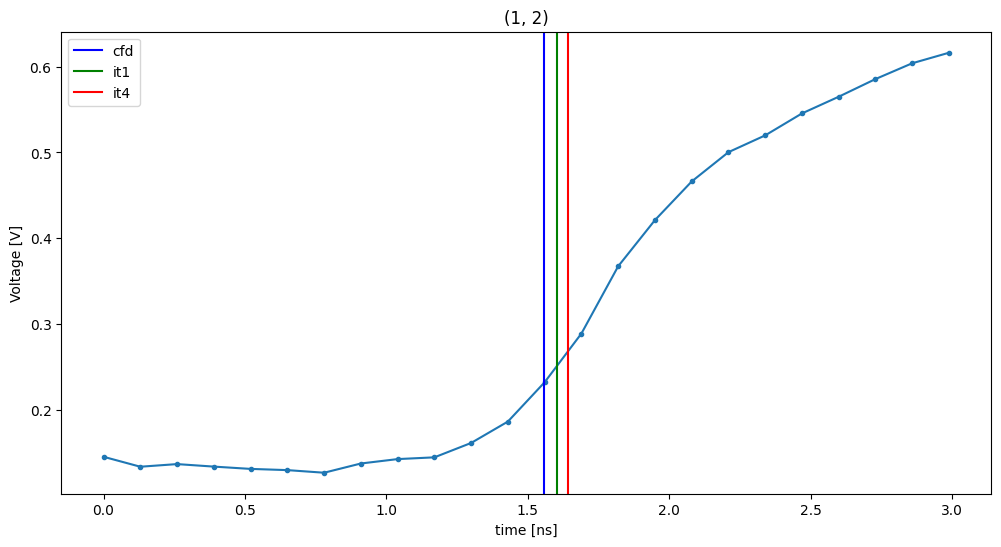

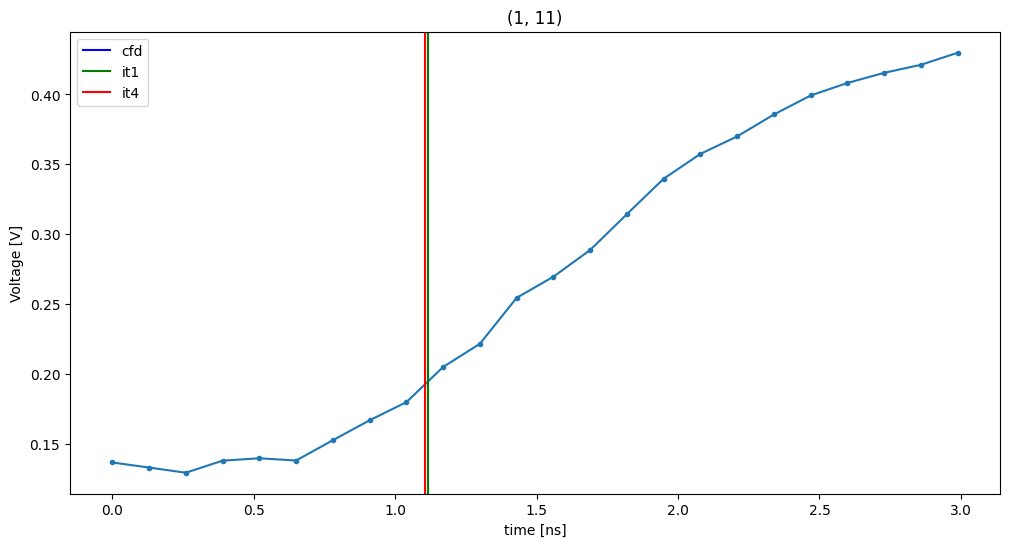

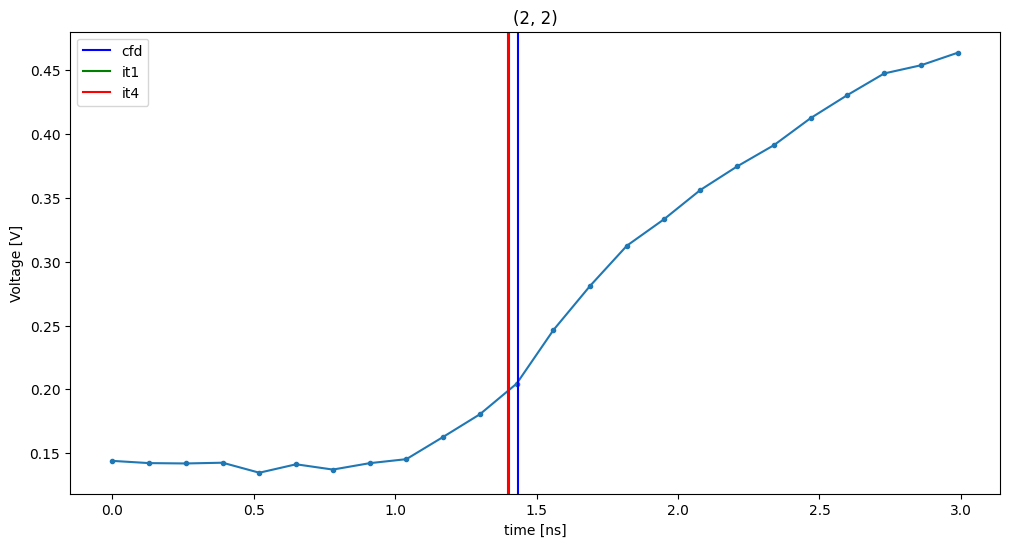

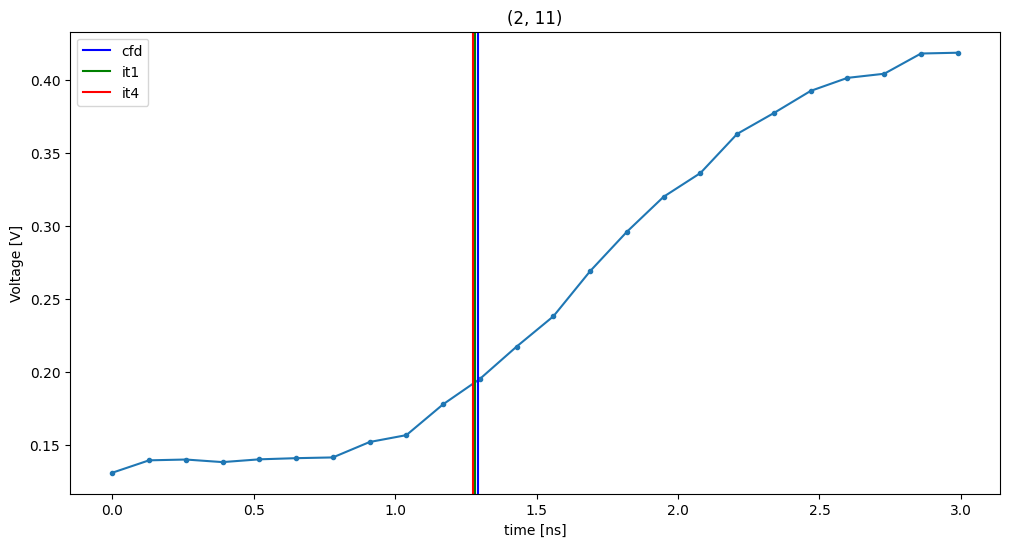

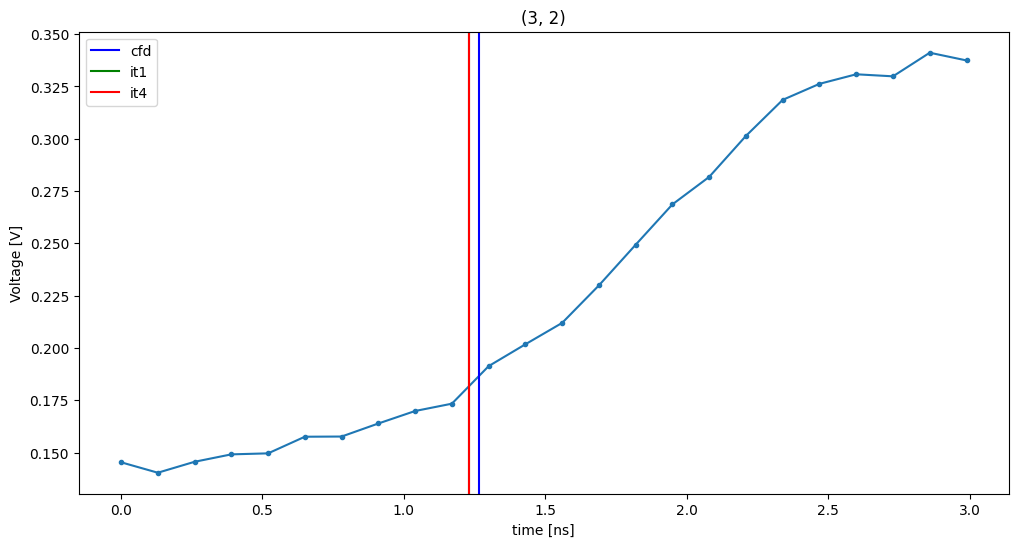

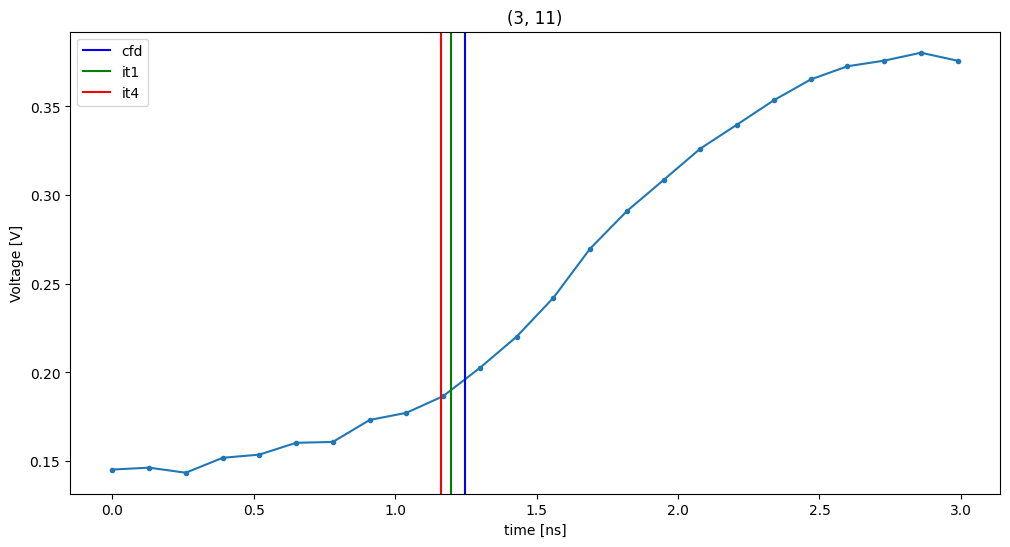

In [34]:
idx_list = [
    (2, (1, 2)),
    (100, (1, 11)),
    (238, (2, 2)),
    (1001, (2, 11)),
    (2137, (3, 2)),
    (2138, (3, 11)),
]

for idx, p_ch in idx_list:
    plt.figure(figsize=(12, 6))
    plt.plot(X_TIME, val_dataset_it4.wav[p_ch][idx], marker='.')
    plt.axvline(val_dataset.t_pred[p_ch][idx], c='blue', label='cfd')
    plt.axvline(val_dataset_it1.t_pred[p_ch][idx], c='green', label='it1')
    # plt.axvline(val_dataset_it2.t_pred[p_ch][idx], c='orange', label='it2')
    # plt.axvline(val_dataset_it3.t_pred[p_ch][idx], c='red', label='it3')
    plt.axvline(val_dataset_it4.t_pred[p_ch][idx], c='red', label='it4')
    plt.title(p_ch)
    plt.xlabel('time [ns]')
    plt.ylabel('Voltage [V]')
    plt.legend()
    plt.show()